In [1]:
import numpy as np
import pandas as pd
import sys, os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), os.pardir)))
from pyfrechet.metric_spaces import Sphere
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import vonmises_fisher
import seaborn as sns
from scipy import stats

## Functions

In [2]:
def pb_coverage_results():
    """ Compute empirical OOB_quantile for different confidence levels. """
    coverage_df = pd.DataFrame(columns=['sample_index', 'train_size', 'kappa', 'OOB_quantile', 'i_cov', 'ii_cov', 'iii_cov', 'iv_cov'])
    i = 0
    for file in os.listdir(os.path.join(os.getcwd(), 'results')):
        if (file.endswith('.npy')):# and file.split('_')[3][5:] == '100'):
            print(i)
            i+=1
            infile=open(os.path.join(os.getcwd(), 'results/' + file), 'rb')
            result=np.load(infile, allow_pickle=True).item()
            infile.close()
        else:
            continue
        coverage_df = pd.concat([coverage_df, pd.DataFrame({
            'sample_index': int(file.split('_')[1][4:]),
            'train_size': int(file.split('_')[2][1:]),
            'kappa': file.split('_')[3][5:],
            'i_cov': [result['i_cov']],
            'ii_cov': [result['ii_cov']],
            'iii_cov': [result['iii_cov']],
            'iv_cov': [result['iv_cov']],
            'OOB_quantile': [result['OOB_quantile']],
        }, index=pd.RangeIndex(0, 1))], ignore_index=True)

    coverage_df['train_size'] = coverage_df['train_size'].astype('category')
    coverage_df['kappa'] = coverage_df.kappa.astype('category')
    return coverage_df


# Function defining the regression mean m_0(theta) on S^2
def m_0(theta, mu):
    """
    Compute the regression mean on S^2.
    
    Parameters:
    theta : array-like
        Angles in [0, 2pi) that parameterize the great circle.
    mu : array-like, shape (2,)
        A unit vector defining the orientation of the great circle.
    
    Returns:
    array, shape (n, 3)
        The mean directions on S^2.
    """
    theta = np.asarray(theta)
    mu = np.asarray(mu)
    assert mu.shape == (2,) and np.isclose(np.linalg.norm(mu), 1), "mu must be a unit vector in R^2"
    
    x1 = np.cos(theta)
    x2 = np.sin(theta) * mu[0]
    x3 = np.sin(theta) * mu[1]
    
    return np.column_stack((x1, x2, x3))

# Function to generate vMF samples
def simulate_data(kappa, mu, theta_samples):
    """
    Generate samples from the von Mises-Fisher distribution on S^2.
    
    Parameters:
    sample_size : int
        Number of samples to generate.
    kappa : float
        Concentration parameter of the vMF distribution.
    mu : array-like, shape (2,)
        The unit vector defining the great circle.
    
    Returns:
    dict
        A dictionary containing input angles and generated samples.
    """
    mean_directions = m_0(theta_samples, mu)  # Compute means on S^2
    
    samples = [vonmises_fisher(mean, kappa).rvs() for mean in mean_directions]
    
    return theta_samples, np.array(samples)

# Parameters
sample_sizes = [50, 100, 200, 500]  # Sample sizes
kappa_values = [50, 200]  # Concentration parameters
mu = np.array([1/np.sqrt(2), 1/np.sqrt(2)])  # Fixed unit vector in R^2

Prediction balls

In [3]:
# Define confidence levels
M = Sphere(2)
np.random.seed(1000)
sign_level = np.array([0.01, 0.05, 0.1])
# Load stored results
pb_coverage_df=pb_coverage_results()
pb_coverage_df.head()

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

,sample_index,train_size,kappa,OOB_quantile,i_cov,ii_cov,iii_cov,iv_cov
0,694,200,50,"[0.4902669856094446, 0.37472676624138135, 0.34...","[[True, True, True], [True, True, True], [True...","[0.994, 0.958, 0.929]","[[True, True, True], [True, True, True], [True...","[0.996, 0.953, 0.929]"
1,470,50,50,"[0.554984804435272, 0.5310272188359274, 0.4184...","[[True, True, True], [True, True, True], [True...","[0.984, 0.984, 0.951]","[[True, True, True], [True, True, True], [True...","[0.999, 0.999, 0.976]"
2,403,50,200,"[0.6392080307927723, 0.603149665132081, 0.2998...","[[True, True, True], [True, True, True], [True...","[0.981, 0.975, 0.865]","[[True, True, True], [True, True, True], [True...","[1.0, 1.0, 0.999]"
3,618,200,50,"[0.40969641996114753, 0.33864612082575973, 0.3...","[[True, True, True], [True, True, True], [True...","[0.972, 0.912, 0.872]","[[True, True, True], [True, True, True], [True...","[0.976, 0.918, 0.878]"
4,765,100,200,"[0.3086542870590066, 0.2476622970825307, 0.203...","[[True, True, True], [True, True, True], [True...","[0.988, 0.975, 0.941]","[[True, True, True], [True, True, True], [True...","[1.0, 0.996, 0.971]"


# TYPE I

In [19]:
import pandas as pd
import numpy as np

def calculate_type_i_coverage(pb_coverage_df, sample_sizes, kappa_values, B=500, random_seed=1):
    """
    Calculate Type I coverage using bootstrap procedure.
    
    Parameters:
    -----------
    pb_coverage_df : DataFrame
        Coverage results dataframe
    sample_sizes : list
        List of sample sizes to analyze
    kappa_values : list
        List of kappa values to analyze
    B : int
        Number of bootstrap replicates (default: 1000)
    
    Returns:
    --------
    dict : Bootstrap results with means and standard deviations
    """

    if random_seed is not None:
        np.random.seed(random_seed)
    
    pb_diccionario_i = {
        'kappa_50': {'50': {'means': np.zeros(3), 'stds': np.zeros(3)}, 
                     '100': {'means': np.zeros(3), 'stds': np.zeros(3)}, 
                     '200': {'means': np.zeros(3), 'stds': np.zeros(3)}, 
                     '500': {'means': np.zeros(3), 'stds': np.zeros(3)}},
        'kappa_200': {'50': {'means': np.zeros(3), 'stds': np.zeros(3)}, 
                      '100': {'means': np.zeros(3), 'stds': np.zeros(3)}, 
                      '200': {'means': np.zeros(3), 'stds': np.zeros(3)}, 
                      '500': {'means': np.zeros(3), 'stds': np.zeros(3)}}
    }

    for N in sample_sizes:
        for kappa in kappa_values:
            print(f"Processing N={N}, kappa={kappa}")

            # Filter data for current N and kappa
            pb_coverage_df_N_kappa = pb_coverage_df[
                (pb_coverage_df['kappa'] == str(kappa)) & 
                (pb_coverage_df['train_size'] == N)
            ]

            # Get M (number of samples for this N, kappa combination) and assert it is 1000
            M = len(pb_coverage_df_N_kappa)
            print(M)
            #assert M == 1000, f"Expected M to be 1000, but got {M} for N={N}, kappa={kappa}"


            # ONLY FOR STANDARD DEVIATIONS
            # Bootstrap procedure
            pb_bootstrap_estimates = []  # Will store B bootstrap estimates
            for b in range(B):
                # Sample M indices for test pairs (i_1^(b), ..., i_M^(b))
                i_indices = np.random.choice(M, size=M, replace=True)
                
                # Sample M indices for training samples (j_1^(b), ..., j_M^(b))
                j_indices = np.random.choice(M, size=M, replace=True)
                
                # Extract bootstrap sample
                pb_bootstrap_coverages = []

                for m in range(M):
                    # Extract row j_m^(b) of the dataset (training sample)
                    training_sample_idx = j_indices[m]
                    training_sample = pb_coverage_df_N_kappa.iloc[training_sample_idx]

                    # Extract element i_m^(b) from the i_cov column (test pair)
                    test_pair_idx = i_indices[m]
                    pb_coverage_for_this_pair = training_sample['i_cov'][test_pair_idx, :]  # Shape: (3,)

                    pb_bootstrap_coverages.append(pb_coverage_for_this_pair)

                # Convert to array and compute mean across the M bootstrap samples
                pb_bootstrap_coverages = np.array(pb_bootstrap_coverages)  # Shape: (M, 3)
                p_hat_M_b = np.mean(pb_bootstrap_coverages, axis=0)  # Shape: (3,)
                # Compute overall mean and standard deviation
                #p_bar_M = np.mean(pb_bootstrap_estimates, axis=0)  # Shape: (3,)
                pb_bootstrap_estimates.append(p_hat_M_b)

            pb_bootstrap_estimates = np.array(pb_bootstrap_estimates)  # Shape: (B, 3)

            sigma_boot = np.std(pb_bootstrap_estimates, axis=0, ddof=1)  # Shape: (3,)

            #pb_bootstrap_estimates.append(p_hat_M_b)

            pb_coverages = []  # Will store bootstrap coverages
            for m in range(M):
                # Extract row j_m^(b) of the dataset (training sample)
                training_sample_idx = m
                training_sample = pb_coverage_df_N_kappa.iloc[training_sample_idx]

                # Extract element i_m^(b) from the i_cov column (test pair)
                test_pair_idx = m
                pb_coverage_for_this_pair = training_sample['i_cov'][test_pair_idx, :]  # Shape: (3,)

                pb_coverages.append(pb_coverage_for_this_pair)

            # Convert to array and compute mean across the M bootstrap samples
            pb_coverages = np.array(pb_coverages)  # Shape: (M, 3)
            p_hat_M = np.mean(pb_coverages, axis=0)  # Shape: (3,)



            # Store results
            kappa_key = f'kappa_{kappa}'
            N_key = str(N)
            pb_diccionario_i[kappa_key][N_key]['means'] = p_hat_M
            pb_diccionario_i[kappa_key][N_key]['stds'] = sigma_boot

            # Print results
            print(f"PB Bootstrap means: {p_hat_M}")
            print(f"PB Bootstrap stds: {sigma_boot}")
    
    return pb_diccionario_i

# Usage
sample_sizes = [50, 100, 200, 500]
kappa_values = [50, 200]  # Concentration parameters

pb_diccionario_i = calculate_type_i_coverage(
    pb_coverage_df=pb_coverage_df, 
    sample_sizes=sample_sizes, 
    kappa_values=kappa_values,
    B=500,  # Number of bootstrap replicates
    random_seed=1  # Optional: set a random seed for reproducibility
)

Processing N=50, kappa=50
1000
PB Bootstrap means: [0.979 0.941 0.884]
PB Bootstrap stds: [0.00403238 0.00726634 0.01001661]
Processing N=50, kappa=200
1000
PB Bootstrap means: [0.988 0.953 0.894]
PB Bootstrap stds: [0.00423072 0.00726971 0.01025788]
Processing N=100, kappa=50
1000
PB Bootstrap means: [0.985 0.944 0.895]
PB Bootstrap stds: [0.00412134 0.00739305 0.0096691 ]
Processing N=100, kappa=200
1000
PB Bootstrap means: [0.982 0.936 0.89 ]
PB Bootstrap stds: [0.00417769 0.00776232 0.01022502]
Processing N=200, kappa=50
1000
PB Bootstrap means: [0.985 0.938 0.883]
PB Bootstrap stds: [0.00373182 0.00777744 0.00979921]
Processing N=200, kappa=200
1000
PB Bootstrap means: [0.987 0.94  0.883]
PB Bootstrap stds: [0.00389677 0.00785134 0.01071822]
Processing N=500, kappa=50
1000
PB Bootstrap means: [0.985 0.939 0.889]
PB Bootstrap stds: [0.00373147 0.00721007 0.00992831]
Processing N=500, kappa=200
1000
PB Bootstrap means: [0.984 0.952 0.907]
PB Bootstrap stds: [0.00382423 0.00725858 0.

Prediction balls

In [44]:
# Prepare data for the DataFrame
pb_rows = []
index = []

for kappa in [50, 200]:
    for N in [50, 100, 200, 500]:
        pb_row = []
        pb_means = pb_diccionario_i[f'kappa_{kappa}'][str(N)]['means']
        pb_stds = pb_diccionario_i[f'kappa_{kappa}'][str(N)]['stds']
        # Format as "mean (std)"
        pb_formatted_values = [f"{100*pb_means[i]:.1f} ({100*pb_stds[i]:.2f})" for i in range(3)]
        pb_row.extend(pb_formatted_values)
        pb_rows.append(pb_row)
        index.append((f"{kappa}", f"{N}"))

# MultiIndex for rows and columns
row_index = pd.MultiIndex.from_tuples(index, names=["kappa", "N"])
col_index = pd.MultiIndex.from_product(
    [["0.01", "0.05", "0.1"]],
    names=[r"Significance Level"]
)

# Create the DataFrame
pb_df = pd.DataFrame(pb_rows, index=row_index, columns=col_index)

# Display the DataFrame
pb_df

Significance Level         0.01         0.05          0.1
kappa N                                                  
50    50            97.9 (0.40)  94.1 (0.73)  88.4 (1.00)
      100           98.5 (0.41)  94.4 (0.74)  89.5 (0.97)
      200           98.5 (0.37)  93.8 (0.78)  88.3 (0.98)
      500           98.5 (0.37)  93.9 (0.72)  88.9 (0.99)
200   50            98.8 (0.42)  95.3 (0.73)  89.4 (1.03)
      100           98.2 (0.42)  93.6 (0.78)  89.0 (1.02)
      200           98.7 (0.39)  94.0 (0.79)  88.3 (1.07)
      500           98.4 (0.38)  95.2 (0.73)  90.7 (1.01)

In [46]:
import pandas as pd
import numpy as np
from scipy import stats

def format_cell(value, target_coverage=0.95, n_trials=1000, confidence_level=0.95):
    """
    Format cell with underline if mean coverage falls outside binomial proportion CI
    
    Parameters:
    value: string in format "mean (std)"
    target_coverage: expected coverage (0.99, 0.95, or 0.90)
    n_trials: number of trials (1000)
    confidence_level: confidence level for CI (0.95 for 95%)
    """
    pb_mean, pb_std = value.split(" ")
    mean_val = float(pb_mean) / 100.0  # Convert percentage back to proportion
    pb_mean = f"{float(pb_mean):.1f}"
    pb_std = pb_std.strip("()")
    pb_std = f"({float(pb_std):.2f})"
    
    # Calculate expected number of successes for target coverage
    expected_successes = int(target_coverage * n_trials)
    
    # Use scipy.stats.binomtest to get proportion confidence interval
    binom_result = stats.binomtest(expected_successes, n_trials)
    lower_bound, upper_bound = binom_result.proportion_ci(confidence_level=confidence_level)
    
    # Check if mean falls outside the confidence interval
    if mean_val < lower_bound or mean_val > upper_bound:
        # Underline the mean value in LaTeX
        pb_mean = f"\\underline{{{pb_mean}}}"
    
    return f"{pb_mean} {pb_std}"

# Define target coverage values that correspond to each column
# Column 0 (0.01): 0.99, Column 1 (0.05): 0.95, Column 2 (0.1): 0.90
target_coverages = [0.99, 0.95, 0.90]

# Apply formatting with column-specific target coverage
pb_latex = pb_df.copy()
for col_idx, col in enumerate(pb_df.columns):
    # Use the target coverage corresponding to this column
    target_coverage = target_coverages[col_idx]
    
    for row_idx in pb_df.index:
        pb_latex.loc[row_idx, col] = format_cell(
            pb_df.loc[row_idx, col], 
            target_coverage=target_coverage, 
            n_trials=1000
        )

pb_latex

Significance Level                     0.01         0.05          0.1
kappa N                                                              
50    50            \underline{97.9} (0.40)  94.1 (0.73)  88.4 (1.00)
      100                       98.5 (0.41)  94.4 (0.74)  89.5 (0.97)
      200                       98.5 (0.37)  93.8 (0.78)  88.3 (0.98)
      500                       98.5 (0.37)  93.9 (0.72)  88.9 (0.99)
200   50                        98.8 (0.42)  95.3 (0.73)  89.4 (1.03)
      100                       98.2 (0.42)  93.6 (0.78)  89.0 (1.02)
      200                       98.7 (0.39)  94.0 (0.79)  88.3 (1.07)
      500                       98.4 (0.38)  95.2 (0.73)  90.7 (1.01)

In [47]:
print(pb_latex.to_latex(index=True, multirow=True, multicolumn=True, multicolumn_format='c', bold_rows=False, float_format= "%.3f" , caption='Type I error', label='tab:pbtypeIerrorcoverage'))

\begin{table}
\caption{Type I error}
\label{tab:pbtypeIerrorcoverage}
\begin{tabular}{lllll}
\toprule
 & Significance Level & ('0.01',) & ('0.05',) & ('0.1',) \\
kappa & N &  &  &  \\
\midrule
\multirow[t]{4}{*}{50} & 50 & \underline{97.9} (0.40) & 94.1 (0.73) & 88.4 (1.00) \\
 & 100 & 98.5 (0.41) & 94.4 (0.74) & 89.5 (0.97) \\
 & 200 & 98.5 (0.37) & 93.8 (0.78) & 88.3 (0.98) \\
 & 500 & 98.5 (0.37) & 93.9 (0.72) & 88.9 (0.99) \\
\cline{1-5}
\multirow[t]{4}{*}{200} & 50 & 98.8 (0.42) & 95.3 (0.73) & 89.4 (1.03) \\
 & 100 & 98.2 (0.42) & 93.6 (0.78) & 89.0 (1.02) \\
 & 200 & 98.7 (0.39) & 94.0 (0.79) & 88.3 (1.07) \\
 & 500 & 98.4 (0.38) & 95.2 (0.73) & 90.7 (1.01) \\
\cline{1-5}
\bottomrule
\end{tabular}
\end{table}



# TYPE II

### KAPPA 50

In [26]:
ii_pb_coverage_df_kappa_50_alpha_01 = pb_coverage_df[pb_coverage_df['kappa'] == '50'].copy()
ii_pb_coverage_df_kappa_50_alpha_05 = pb_coverage_df[pb_coverage_df['kappa'] == '50'].copy()
ii_pb_coverage_df_kappa_50_alpha_1  = pb_coverage_df[pb_coverage_df['kappa'] == '50'].copy()

ii_pb_coverage_df_kappa_50_alpha_01['ii_cov']  = pb_coverage_df[pb_coverage_df['kappa'] == '50']['ii_cov'].apply(lambda x: x[0])
ii_pb_coverage_df_kappa_50_alpha_01['OOB_quantile'] = pb_coverage_df[pb_coverage_df['kappa'] == '50']['OOB_quantile'].apply(lambda x: x[0])

ii_pb_coverage_df_kappa_50_alpha_05['ii_cov']  = pb_coverage_df[pb_coverage_df['kappa'] == '50']['ii_cov'].apply(lambda x: x[1])
ii_pb_coverage_df_kappa_50_alpha_05['OOB_quantile'] = pb_coverage_df[pb_coverage_df['kappa'] == '50']['OOB_quantile'].apply(lambda x: x[1])

ii_pb_coverage_df_kappa_50_alpha_1['ii_cov']  = pb_coverage_df[pb_coverage_df['kappa'] == '50']['ii_cov'].apply(lambda x: x[2])
ii_pb_coverage_df_kappa_50_alpha_1['OOB_quantile'] = pb_coverage_df[pb_coverage_df['kappa'] == '50']['OOB_quantile'].apply(lambda x: x[2])

ii_pb_coverage_df_kappa_50_alpha_01.head()
ii_pb_coverage_df_kappa_50_alpha_05.head()
ii_pb_coverage_df_kappa_50_alpha_1.head()

,sample_index,train_size,kappa,OOB_quantile,i_cov,ii_cov,iii_cov,iv_cov
0,694,200,50,0.348731,"[[True, True, True], [True, True, True], [True...",0.929,"[[True, True, True], [True, True, True], [True...","[0.996, 0.953, 0.929]"
1,470,50,50,0.418418,"[[True, True, True], [True, True, True], [True...",0.951,"[[True, True, True], [True, True, True], [True...","[0.999, 0.999, 0.976]"
3,618,200,50,0.313103,"[[True, True, True], [True, True, True], [True...",0.872,"[[True, True, True], [True, True, True], [True...","[0.976, 0.918, 0.878]"
5,935,50,50,0.361734,"[[True, True, True], [True, True, True], [True...",0.896,"[[True, True, True], [True, True, True], [True...","[1.0, 0.995, 0.962]"
6,953,500,50,0.326489,"[[True, True, True], [True, True, True], [True...",0.898,"[[True, True, False], [True, True, True], [Tru...","[0.986, 0.963, 0.932]"


In [27]:
ii_pb_coverage_df_kappa_200_alpha_01 = pb_coverage_df[pb_coverage_df['kappa'] == '200'].copy()
ii_pb_coverage_df_kappa_200_alpha_05 = pb_coverage_df[pb_coverage_df['kappa'] == '200'].copy()
ii_pb_coverage_df_kappa_200_alpha_1  = pb_coverage_df[pb_coverage_df['kappa'] == '200'].copy()

ii_pb_coverage_df_kappa_200_alpha_01['ii_cov'] = pb_coverage_df[pb_coverage_df['kappa'] == '200']['ii_cov'].apply(lambda x: x[0])
ii_pb_coverage_df_kappa_200_alpha_01['OOB_quantile'] = pb_coverage_df[pb_coverage_df['kappa'] == '200']['OOB_quantile'].apply(lambda x: x[0])

ii_pb_coverage_df_kappa_200_alpha_05['ii_cov'] = pb_coverage_df[pb_coverage_df['kappa'] == '200']['ii_cov'].apply(lambda x: x[1])
ii_pb_coverage_df_kappa_200_alpha_05['OOB_quantile'] = pb_coverage_df[pb_coverage_df['kappa'] == '200']['OOB_quantile'].apply(lambda x: x[1])

ii_pb_coverage_df_kappa_200_alpha_1['ii_cov'] = pb_coverage_df[pb_coverage_df['kappa'] == '200']['ii_cov'].apply(lambda x: x[2])
ii_pb_coverage_df_kappa_200_alpha_1['OOB_quantile'] = pb_coverage_df[pb_coverage_df['kappa'] == '200']['OOB_quantile'].apply(lambda x: x[2])

ii_pb_coverage_df_kappa_200_alpha_01.head()
ii_pb_coverage_df_kappa_200_alpha_05.head()
ii_pb_coverage_df_kappa_200_alpha_1.head()

,sample_index,train_size,kappa,OOB_quantile,i_cov,ii_cov,iii_cov,iv_cov
2,403,50,200,0.299835,"[[True, True, True], [True, True, True], [True...",0.865,"[[True, True, True], [True, True, True], [True...","[1.0, 1.0, 0.999]"
4,765,100,200,0.203070,"[[True, True, True], [True, True, True], [True...",0.941,"[[True, True, True], [True, True, True], [True...","[1.0, 0.996, 0.971]"
7,302,50,200,0.203302,"[[True, True, True], [True, True, False], [Tru...",0.835,"[[True, True, True], [True, True, True], [True...","[1.0, 1.0, 0.971]"
8,944,50,200,0.242759,"[[True, True, True], [True, True, True], [True...",0.877,"[[True, True, True], [True, True, True], [True...","[1.0, 1.0, 0.998]"
9,314,200,200,0.154204,"[[True, True, True], [False, False, False], [T...",0.827,"[[True, True, True], [True, True, True], [True...","[0.997, 0.931, 0.848]"


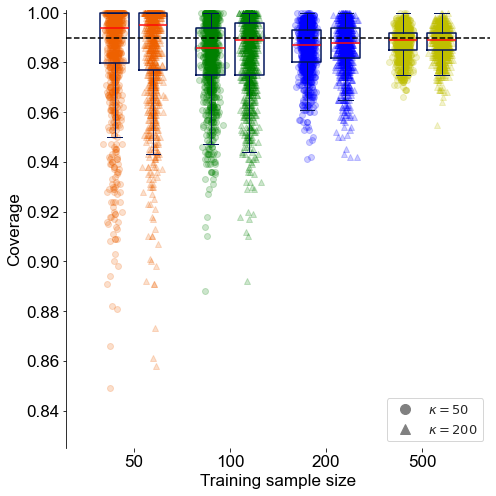

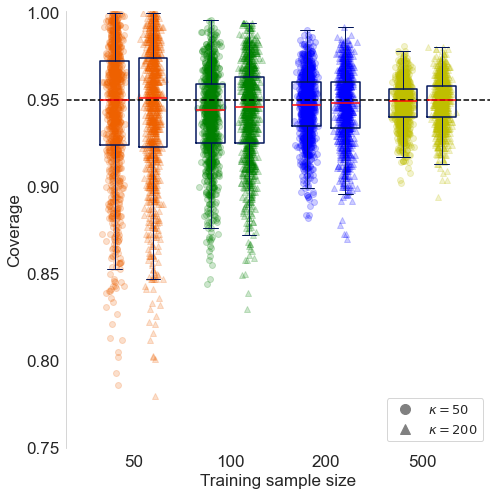

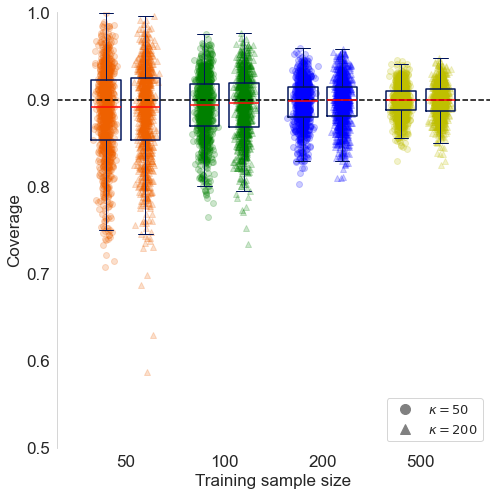

In [28]:
import matplotlib.patches as mpatches
import matplotlib.lines as mlines

##### Set style options here #####
boxprops = dict(linestyle='-', linewidth=1.5, color='#00145A')
flierprops = dict(marker='o', markersize=1, linestyle='none')
whiskerprops = dict(color='#00145A')
capprops = dict(color='#00145A')
medianprops = dict(linewidth=1.5, linestyle='-', color='#ff0808')

for kappa_50_data, kappa_200_data, alpha_level in zip(
    [ii_pb_coverage_df_kappa_50_alpha_01, ii_pb_coverage_df_kappa_50_alpha_05, ii_pb_coverage_df_kappa_50_alpha_1], 
    [ii_pb_coverage_df_kappa_200_alpha_01, ii_pb_coverage_df_kappa_200_alpha_05, ii_pb_coverage_df_kappa_200_alpha_1], 
    [0.01, 0.05, 0.1]
):
    fig = plt.figure(facecolor="white", figsize=(7, 7))
    ax = fig.add_subplot(111)

    # Extract data for each training size
    train_sizes = [50, 100, 200, 500]
    kappa_50_boxplot_data = [kappa_50_data[kappa_50_data['train_size'] == size]['ii_cov'].values for size in train_sizes]
    kappa_200_boxplot_data = [kappa_200_data[kappa_200_data['train_size'] == size]['ii_cov'].values for size in train_sizes]

    # Create boxplots with adjusted positions
    positions_kappa_50 = np.array(range(len(train_sizes))) - 0.2
    positions_kappa_200 = np.array(range(len(train_sizes))) + 0.2

    ax.boxplot(kappa_50_boxplot_data, positions=positions_kappa_50, widths=0.3, notch=False, 
               boxprops=dict(color='#00145A', linestyle='-', linewidth=1.5), 
               whiskerprops=dict(color='#00145A'), capprops=dict(color='#00145A'), 
               flierprops=dict(marker='o', markersize=1, linestyle='none'), 
               medianprops=dict(linewidth=1.5, linestyle='-', color='#ff0808'), showmeans=False, showfliers=False)
               
    ax.boxplot(kappa_200_boxplot_data, positions=positions_kappa_200, widths=0.3, notch=False, 
               boxprops=dict(color='#00145A', linestyle='-', linewidth=1.5), 
               whiskerprops=dict(color='#00145A'), capprops=dict(color='#00145A'), 
               flierprops=dict(marker='o', markersize=1, linestyle='none'), 
               medianprops=dict(linewidth=1.5, linestyle='-', color='#ff0808'), showmeans=False, showfliers=False)
    
    sns.set_style("whitegrid")
    # Scatter plot
    palette_kappa_50 = ['#ee6100', 'g', 'b', 'y']
    palette_kappa_200 = ['#ee6100', 'g', 'b', 'y']

    for i, size in enumerate(train_sizes):
        xs_kappa_50 = np.random.normal(positions_kappa_50[i], 0.04, len(kappa_50_boxplot_data[i]))
        xs_kappa_200 = np.random.normal(positions_kappa_200[i], 0.04, len(kappa_200_boxplot_data[i]))

        ax.scatter(xs_kappa_50, kappa_50_boxplot_data[i], alpha=0.2, color=palette_kappa_50[i])
        ax.scatter(xs_kappa_200, kappa_200_boxplot_data[i], alpha=0.2, color=palette_kappa_200[i], marker='^')

    sns.despine(bottom=True)  # Remove right and top axis lines

    ax.set_xticks(range(len(train_sizes)))
    ax.set_xticklabels([str(size) for size in train_sizes], fontsize=17)

    if alpha_level == 0.01:
        ax.set_ylim(0.825, 1.001)
    elif alpha_level == 0.05:
        ax.set_ylim(0.75, 1.001)
    else:
        ax.set_ylim(0.5, 1.001)

    ax.set_xlabel('Training sample size', fontsize=17)
    ax.set_ylabel('Coverage', fontsize=17)
    ax.tick_params(labelsize=17)
    ax.axhline(y=1-alpha_level, color='black', linestyle='dashed')
    ax.grid(False)

    # Custom legend
    legend_handles = [
        # mpatches.Patch(color=palette_kappa_50[j], label=f'Train Size: {train_sizes[j]}')
        # for j in range(len(train_sizes))
    ]
        
    legend_handles.append(mlines.Line2D([], [], color='gray', marker='o', linestyle='none', markersize=10, label=r'$\kappa = 50$'))
    legend_handles.append(mlines.Line2D([], [], color='gray', marker='^', linestyle='none', markersize=10, label=r'$\kappa = 200$'))
    ax.legend(handles=legend_handles, loc='lower right', fontsize=13)

    fig.tight_layout()
    filename = os.path.join(os.getcwd(),'pb_sphere_kappa_50_200_II_coverage_' + str(alpha_level)[2:] + '.png')
    fig.savefig(filename, bbox_inches='tight', format='png', dpi = 75, transparent=True)
    plt.show()

In [30]:
ii_pb_coverage_df_alpha_01 = pb_coverage_df.copy()
ii_pb_coverage_df_alpha_05 = pb_coverage_df.copy()
ii_pb_coverage_df_alpha_1  = pb_coverage_df.copy()

ii_pb_coverage_df_alpha_01['OOB_quantile'] = pb_coverage_df['OOB_quantile'].apply(lambda x: x[0])
ii_pb_coverage_df_alpha_05['OOB_quantile'] = pb_coverage_df['OOB_quantile'].apply(lambda x: x[1])
ii_pb_coverage_df_alpha_1['OOB_quantile'] = pb_coverage_df['OOB_quantile'].apply(lambda x: x[2])

ii_pb_coverage_df_alpha_01.head()
ii_pb_coverage_df_alpha_05.head()
ii_pb_coverage_df_alpha_1.head()

,sample_index,train_size,kappa,OOB_quantile,i_cov,ii_cov,iii_cov,iv_cov
0,694,200,50,0.348731,"[[True, True, True], [True, True, True], [True...","[0.994, 0.958, 0.929]","[[True, True, True], [True, True, True], [True...","[0.996, 0.953, 0.929]"
1,470,50,50,0.418418,"[[True, True, True], [True, True, True], [True...","[0.984, 0.984, 0.951]","[[True, True, True], [True, True, True], [True...","[0.999, 0.999, 0.976]"
2,403,50,200,0.299835,"[[True, True, True], [True, True, True], [True...","[0.981, 0.975, 0.865]","[[True, True, True], [True, True, True], [True...","[1.0, 1.0, 0.999]"
3,618,200,50,0.313103,"[[True, True, True], [True, True, True], [True...","[0.972, 0.912, 0.872]","[[True, True, True], [True, True, True], [True...","[0.976, 0.918, 0.878]"
4,765,100,200,0.203070,"[[True, True, True], [True, True, True], [True...","[0.988, 0.975, 0.941]","[[True, True, True], [True, True, True], [True...","[1.0, 0.996, 0.971]"


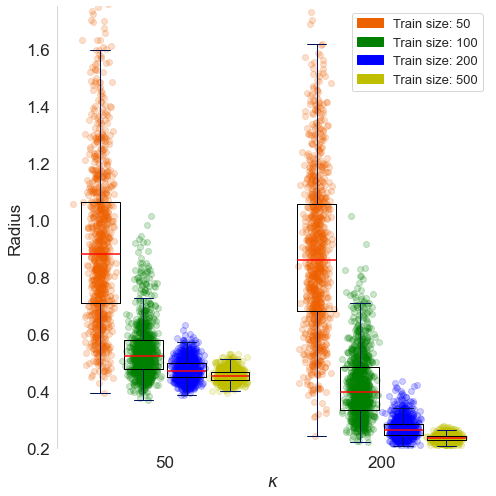

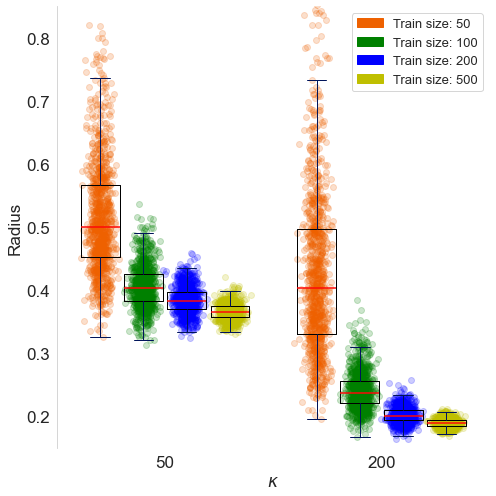

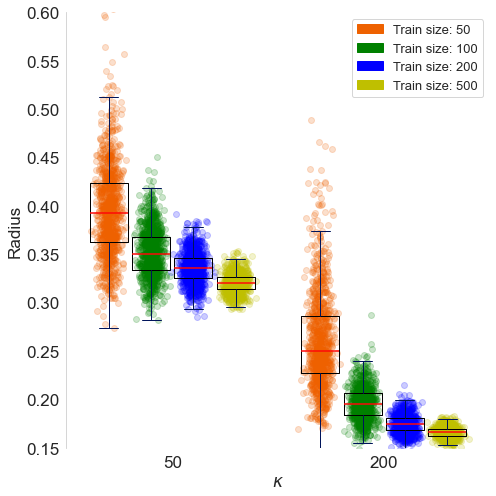

In [31]:
boxprops = dict(linestyle='-', linewidth=1.5, color='#00145A')
flierprops = dict(marker='o', markersize=1, linestyle='none')
whiskerprops = dict(color='#00145A')
capprops = dict(color='#00145A')
medianprops = dict(linewidth=1.5, linestyle='-', color='#ff0808')

for data, alpha_level in zip(
    [ii_pb_coverage_df_alpha_01, ii_pb_coverage_df_alpha_05, ii_pb_coverage_df_alpha_1], 
    [0.01, 0.05, 0.1]):
    if alpha_level == 0.01:
        coverage_df = ii_pb_coverage_df_alpha_01
    elif alpha_level == 0.05:
        coverage_df = ii_pb_coverage_df_alpha_05
    else:
        coverage_df = ii_pb_coverage_df_alpha_1

    # Extract unique train sizes and degrees of freedom
    train_sizes = sorted(coverage_df['train_size'].unique())
    kappas = coverage_df['kappa'].unique()
    # Prepare the data for boxplots
    grouped_data = [
        [coverage_df.loc[(coverage_df['kappa'] == kappa) & (coverage_df['train_size'] == N), 'OOB_quantile']
            for N in train_sizes]
        for kappa in kappas ]
        
    sns.set_style("whitegrid")
    # Plotting
    fig = plt.figure(facecolor="white", figsize=(7, 7))
    ax = fig.add_subplot(111)

    palette = ['#ee6100', 'g', 'b', 'y']  # Generate unique colors

    for i, group in enumerate(grouped_data):
        #In this loop, select the degrees of freedom
        base_position = 1 + i * (len(train_sizes) + 1)  # spacing between groups

        for j, ts_data in enumerate(group):
            #In this loop, select the train sizes. ts_data is the dataset for train size and df
            pos = base_position + j
            ax.boxplot(ts_data, positions=[pos], widths = .9, notch=False, whiskerprops=whiskerprops,capprops=capprops, flierprops=flierprops, medianprops=medianprops,showmeans=False, showfliers=False) 
    
            palette = ['#ee6100', 'g', 'b', 'y']
            for x, val in zip(np.random.normal(pos, 0.14, ts_data.shape[0]), ts_data):
                ax.scatter(x, val, alpha=0.2, color = palette[j])


    sns.despine(bottom=True) # removes right and top axis lines

    # Formatting
    ax.set_xticks(
        ticks=[1 + i * (len(train_sizes) + 1) + (len(train_sizes) - 1) / 2 for i in range(len(kappas))],
        labels=kappas
    )
    ax.set_xlim(0, len(kappas) * (len(train_sizes) + 1))
    if alpha_level == 0.01:
        ax.set_ylim(0.2, 1.75)
    elif alpha_level == 0.05:
        ax.set_ylim(0.15, 0.85)
    else:
        ax.set_ylim(0.15, 0.6)
        
    ax.set_xlabel(r'$\kappa$', fontsize=17)
    ax.set_ylabel('Radius', fontsize=17)
    ax.tick_params(axis='x', labelsize=17)
    ax.tick_params(axis='y', labelsize=17)
    legend_handles = [
        mpatches.Patch(color=palette[j], label=f'Train size: {train_sizes[j]}') 
        for j in range(len(train_sizes))
    ]
    ax.legend(handles=legend_handles, loc='upper right', fontsize=13)
    ax.grid(False)
    fig.tight_layout()
    
    filename = os.path.join(os.getcwd(), 'pb_sphere_radius_vs_kappa' + str(alpha_level)[2:] + '.png')
    fig.savefig(filename, bbox_inches = 'tight', format='png', dpi=75, transparent=True)
    plt.show()

# TYPE III

In [ ]:
def calculate_type_iii_coverage(pb_coverage_df, sample_sizes, kappa_values, B=500, random_seed=1):
    """
    Calculate Type III coverage using bootstrap procedure.
    
    Parameters:
    -----------
    pb_coverage_df : DataFrame
        Coverage results dataframe
    sample_sizes : list
        List of sample sizes to analyze
    kappa_values : list
        List of kappa values to analyze
    B : int
        Number of bootstrap replicates (default: 1000)
    
    Returns:
    --------
    dict : Bootstrap results with means and standard deviations
    """

    if random_seed is not None:
        np.random.seed(random_seed)
    
    pb_diccionario_iii = {
        'kappa_50': {'50': {'means': np.zeros(3), 'stds': np.zeros(3)}, 
                     '100': {'means': np.zeros(3), 'stds': np.zeros(3)}, 
                     '200': {'means': np.zeros(3), 'stds': np.zeros(3)}, 
                     '500': {'means': np.zeros(3), 'stds': np.zeros(3)}},
        'kappa_200': {'50': {'means': np.zeros(3), 'stds': np.zeros(3)}, 
                      '100': {'means': np.zeros(3), 'stds': np.zeros(3)}, 
                      '200': {'means': np.zeros(3), 'stds': np.zeros(3)}, 
                      '500': {'means': np.zeros(3), 'stds': np.zeros(3)}}
    }

    for N in sample_sizes:
        for kappa in kappa_values:
            print(f"Processing N={N}, kappa={kappa}")

            # Filter data for current N and kappa
            pb_coverage_df_N_kappa = pb_coverage_df[
                (pb_coverage_df['kappa'] == str(kappa)) & 
                (pb_coverage_df['train_size'] == N)
            ]

            # Get M (number of samples for this N, kappa combination) and assert it is 1000
            M = len(pb_coverage_df_N_kappa)
            print(M)
            #assert M == 1000, f"Expected M to be 1000, but got {M} for N={N}, kappa={kappa}"


            # ONLY FOR STANDARD DEVIATIONS
            # Bootstrap procedure
            pb_bootstrap_estimates = []  # Will store B bootstrap estimates
            for b in range(B):
                # Sample M indices for test pairs (i_1^(b), ..., i_M^(b))
                i_indices = np.random.choice(M, size=M, replace=True)
                
                # Sample M indices for training samples (j_1^(b), ..., j_M^(b))
                j_indices = np.random.choice(M, size=M, replace=True)
                
                # Extract bootstrap sample
                pb_bootstrap_coverages = []

                for m in range(M):
                    # Extract row j_m^(b) of the dataset (training sample)
                    training_sample_idx = j_indices[m]
                    training_sample = pb_coverage_df_N_kappa.iloc[training_sample_idx]

                    # Extract element i_m^(b) from the i_cov column (test pair)
                    test_pair_idx = i_indices[m]
                    pb_coverage_for_this_pair = training_sample['iii_cov'][test_pair_idx, :]  # Shape: (3,)

                    pb_bootstrap_coverages.append(pb_coverage_for_this_pair)

                # Convert to array and compute mean across the M bootstrap samples
                pb_bootstrap_coverages = np.array(pb_bootstrap_coverages)  # Shape: (M, 3)
                p_hat_M_b = np.mean(pb_bootstrap_coverages, axis=0)  # Shape: (3,)
                # Compute overall mean and standard deviation
                #p_bar_M = np.mean(pb_bootstrap_estimates, axis=0)  # Shape: (3,)
                pb_bootstrap_estimates.append(p_hat_M_b)

            pb_bootstrap_estimates = np.array(pb_bootstrap_estimates)  # Shape: (B, 3)

            sigma_boot = np.std(pb_bootstrap_estimates, axis=0, ddof=1)  # Shape: (3,)

            #pb_bootstrap_estimates.append(p_hat_M_b)

            pb_coverages = []  # Will store bootstrap coverages
            for m in range(M):
                # Extract row j_m^(b) of the dataset (training sample)
                training_sample_idx = m
                training_sample = pb_coverage_df_N_kappa.iloc[training_sample_idx]

                # Extract element i_m^(b) from the i_cov column (test pair)
                test_pair_idx = m
                pb_coverage_for_this_pair = training_sample['iii_cov'][test_pair_idx, :]  # Shape: (3,)

                pb_coverages.append(pb_coverage_for_this_pair)

            # Convert to array and compute mean across the M bootstrap samples
            pb_coverages = np.array(pb_coverages)  # Shape: (M, 3)
            p_hat_M = np.mean(pb_coverages, axis=0)  # Shape: (3,)



            # Store results
            kappa_key = f'kappa_{kappa}'
            N_key = str(N)
            pb_diccionario_iii[kappa_key][N_key]['means'] = p_hat_M
            pb_diccionario_iii[kappa_key][N_key]['stds'] = sigma_boot

            # Print results
            print(f"PB Bootstrap means: {p_hat_M}")
            print(f"PB Bootstrap stds: {sigma_boot}")

    return pb_diccionario_iii

# Usage
sample_sizes = [50, 100, 200, 500]
kappa_values = [50, 200]  # Concentration parameters

pb_diccionario_iii = calculate_type_iii_coverage(
    pb_coverage_df=pb_coverage_df, 
    sample_sizes=sample_sizes, 
    kappa_values=kappa_values,
    B=500,  # Number of bootstrap replicates
    random_seed=1  # Optional: set a random seed for reproducibility
)

Processing N=50, kappa=50
1000
PB Bootstrap means: [1.    0.986 0.944]
PB Bootstrap stds: [0.00079446 0.00328252 0.00697987]
Processing N=50, kappa=200
1000
PB Bootstrap means: [1.    1.    0.982]
PB Bootstrap stds: [0.00020159 0.00160493 0.00447324]
Processing N=100, kappa=50
1000
PB Bootstrap means: [0.993 0.956 0.905]
PB Bootstrap stds: [0.002795   0.00655888 0.00890952]
Processing N=100, kappa=200
1000
PB Bootstrap means: [1.    0.988 0.946]
PB Bootstrap stds: [0.00096564 0.00437699 0.00708002]
Processing N=200, kappa=50
1000
PB Bootstrap means: [0.993 0.95  0.9  ]
PB Bootstrap stds: [0.0030695  0.00667436 0.0090963 ]
Processing N=200, kappa=200
1000
PB Bootstrap means: [0.997 0.969 0.927]
PB Bootstrap stds: [0.0019564  0.0058456  0.00828996]
Processing N=500, kappa=50
1000
PB Bootstrap means: [0.993 0.964 0.921]
PB Bootstrap stds: [0.00302473 0.00629521 0.00881597]
Processing N=500, kappa=200
1000
PB Bootstrap means: [0.993 0.949 0.911]
PB Bootstrap stds: [0.00326319 0.00704239 0.

Prediction balls

In [53]:
# Prepare data for the DataFrame
pb_rows = []
index = []

for kappa in [50, 200]:
    for N in [50, 100, 200, 500]:
        pb_row = []
        pb_means = pb_diccionario_iii[f'kappa_{kappa}'][str(N)]['means']
        pb_stds = pb_diccionario_iii[f'kappa_{kappa}'][str(N)]['stds']
        # Format as "mean (std)"
        pb_formatted_values = [f"{100*pb_means[i]:.1f} ({100*pb_stds[i]:.2f})" for i in range(3)]
        pb_row.extend(pb_formatted_values)
        pb_rows.append(pb_row)
        index.append((f"{kappa}", f"{N}"))

# MultiIndex for rows and columns
row_index = pd.MultiIndex.from_tuples(index, names=["kappa", "N"])
col_index = pd.MultiIndex.from_product(
    [["0.01", "0.05", "0.1"]],
    names=[r"Significance Level"]
)

# Create the DataFrame
pb_df = pd.DataFrame(pb_rows, index=row_index, columns=col_index)

# Display the DataFrame
pb_df

Significance Level          0.01          0.05          0.1
kappa N                                                    
50    50            100.0 (0.08)   98.6 (0.33)  94.4 (0.70)
      100            99.3 (0.28)   95.6 (0.66)  90.5 (0.89)
      200            99.3 (0.31)   95.0 (0.67)  90.0 (0.91)
      500            99.3 (0.30)   96.4 (0.63)  92.1 (0.88)
200   50            100.0 (0.02)  100.0 (0.16)  98.2 (0.45)
      100           100.0 (0.10)   98.8 (0.44)  94.6 (0.71)
      200            99.7 (0.20)   96.9 (0.58)  92.7 (0.83)
      500            99.3 (0.33)   94.9 (0.70)  91.1 (0.96)

In [55]:
# Define target coverage values that correspond to each column
# Column 0 (0.01): 0.99, Column 1 (0.05): 0.95, Column 2 (0.1): 0.90
target_coverages = [0.99, 0.95, 0.90]

# Apply formatting with column-specific target coverage
pb_latex = pb_df.copy()
for col_idx, col in enumerate(pb_df.columns):
    # Use the target coverage corresponding to this column
    target_coverage = target_coverages[col_idx]
    
    for row_idx in pb_df.index:
        pb_latex.loc[row_idx, col] = format_cell(
            pb_df.loc[row_idx, col], 
            target_coverage=target_coverage, 
            n_trials=1000
        )

pb_latex

Significance Level                      0.01                      0.05  \
kappa N                                                                  
50    50            \underline{100.0} (0.08)   \underline{98.6} (0.33)   
      100                        99.3 (0.28)               95.6 (0.66)   
      200                        99.3 (0.31)               95.0 (0.67)   
      500                        99.3 (0.30)   \underline{96.4} (0.63)   
200   50            \underline{100.0} (0.02)  \underline{100.0} (0.16)   
      100           \underline{100.0} (0.10)   \underline{98.8} (0.44)   
      200            \underline{99.7} (0.20)   \underline{96.9} (0.58)   
      500                        99.3 (0.33)               94.9 (0.70)   

Significance Level                      0.1  
kappa N                                      
50    50            \underline{94.4} (0.70)  
      100                       90.5 (0.89)  
      200                       90.0 (0.91)  
      500           \underline{92.1} (0.88)  
200   50            \underline{98.2} (0.45)  
      100           \underline{94.6} (0.71)  
      200           \underline{92.7} (0.83)  
      500                       91.1 (0.96)

In [51]:
print(pb_latex.to_latex(index=True, multirow=True, multicolumn=True, multicolumn_format='c', bold_rows=False, float_format= "%.3f" , caption='Type III error', label='tab:pbtypeIIIerrorcoverage'))

\begin{table}
\caption{Type III error}
\label{tab:pbtypeIIIerrorcoverage}
\begin{tabular}{lllll}
\toprule
 & Significance Level & ('0.01',) & ('0.05',) & ('0.1',) \\
kappa & N &  &  &  \\
\midrule
\multirow[t]{4}{*}{50} & 50 & \underline{100.0} (0.08) & \underline{98.6} (0.33) & \underline{94.4} (0.70) \\
 & 100 & 99.3 (0.28) & 95.6 (0.66) & 90.5 (0.89) \\
 & 200 & 99.3 (0.31) & 95.0 (0.67) & 90.0 (0.91) \\
 & 500 & 99.3 (0.30) & \underline{96.4} (0.63) & \underline{92.1} (0.88) \\
\cline{1-5}
\multirow[t]{4}{*}{200} & 50 & \underline{100.0} (0.02) & \underline{100.0} (0.16) & \underline{98.2} (0.45) \\
 & 100 & \underline{100.0} (0.10) & \underline{98.8} (0.44) & \underline{94.6} (0.71) \\
 & 200 & \underline{99.7} (0.20) & \underline{96.9} (0.58) & \underline{92.7} (0.83) \\
 & 500 & 99.3 (0.33) & 94.9 (0.70) & 91.1 (0.96) \\
\cline{1-5}
\bottomrule
\end{tabular}
\end{table}



# Type IV

### KAPPA 50

In [36]:
iv_pb_coverage_df_kappa_50_alpha_01 = pb_coverage_df[pb_coverage_df['kappa'] == '50'].copy()
iv_pb_coverage_df_kappa_50_alpha_05 = pb_coverage_df[pb_coverage_df['kappa'] == '50'].copy()
iv_pb_coverage_df_kappa_50_alpha_1  = pb_coverage_df[pb_coverage_df['kappa'] == '50'].copy()

iv_pb_coverage_df_kappa_50_alpha_01['iv_cov']  = pb_coverage_df[pb_coverage_df['kappa'] == '50']['iv_cov'].apply(lambda x: x[0])
iv_pb_coverage_df_kappa_50_alpha_01['OOB_quantile'] = pb_coverage_df[pb_coverage_df['kappa'] == '50']['OOB_quantile'].apply(lambda x: x[0])

iv_pb_coverage_df_kappa_50_alpha_05['iv_cov']  = pb_coverage_df[pb_coverage_df['kappa'] == '50']['iv_cov'].apply(lambda x: x[1])
iv_pb_coverage_df_kappa_50_alpha_05['OOB_quantile'] = pb_coverage_df[pb_coverage_df['kappa'] == '50']['OOB_quantile'].apply(lambda x: x[1])

iv_pb_coverage_df_kappa_50_alpha_1['iv_cov']  = pb_coverage_df[pb_coverage_df['kappa'] == '50']['iv_cov'].apply(lambda x: x[2])
iv_pb_coverage_df_kappa_50_alpha_1['OOB_quantile'] = pb_coverage_df[pb_coverage_df['kappa'] == '50']['OOB_quantile'].apply(lambda x: x[2])

iv_pb_coverage_df_kappa_50_alpha_01.head()
iv_pb_coverage_df_kappa_50_alpha_05.head()
iv_pb_coverage_df_kappa_50_alpha_1.head()

,sample_index,train_size,kappa,OOB_quantile,i_cov,ii_cov,iii_cov,iv_cov
0,694,200,50,0.348731,"[[True, True, True], [True, True, True], [True...","[0.994, 0.958, 0.929]","[[True, True, True], [True, True, True], [True...",0.929
1,470,50,50,0.418418,"[[True, True, True], [True, True, True], [True...","[0.984, 0.984, 0.951]","[[True, True, True], [True, True, True], [True...",0.976
3,618,200,50,0.313103,"[[True, True, True], [True, True, True], [True...","[0.972, 0.912, 0.872]","[[True, True, True], [True, True, True], [True...",0.878
5,935,50,50,0.361734,"[[True, True, True], [True, True, True], [True...","[0.999, 0.965, 0.896]","[[True, True, True], [True, True, True], [True...",0.962
6,953,500,50,0.326489,"[[True, True, True], [True, True, True], [True...","[0.989, 0.954, 0.898]","[[True, True, False], [True, True, True], [Tru...",0.932


In [37]:
iv_pb_coverage_df_kappa_200_alpha_01 = pb_coverage_df[pb_coverage_df['kappa'] == '200'].copy()
iv_pb_coverage_df_kappa_200_alpha_05 = pb_coverage_df[pb_coverage_df['kappa'] == '200'].copy()
iv_pb_coverage_df_kappa_200_alpha_1  = pb_coverage_df[pb_coverage_df['kappa'] == '200'].copy()

iv_pb_coverage_df_kappa_200_alpha_01['iv_cov'] = pb_coverage_df[pb_coverage_df['kappa'] == '200']['iv_cov'].apply(lambda x: x[0])
iv_pb_coverage_df_kappa_200_alpha_01['OOB_quantile'] = pb_coverage_df[pb_coverage_df['kappa'] == '200']['OOB_quantile'].apply(lambda x: x[0])

iv_pb_coverage_df_kappa_200_alpha_05['iv_cov'] = pb_coverage_df[pb_coverage_df['kappa'] == '200']['iv_cov'].apply(lambda x: x[1])
iv_pb_coverage_df_kappa_200_alpha_05['OOB_quantile'] = pb_coverage_df[pb_coverage_df['kappa'] == '200']['OOB_quantile'].apply(lambda x: x[1])

iv_pb_coverage_df_kappa_200_alpha_1['iv_cov'] = pb_coverage_df[pb_coverage_df['kappa'] == '200']['iv_cov'].apply(lambda x: x[2])
iv_pb_coverage_df_kappa_200_alpha_1['OOB_quantile'] = pb_coverage_df[pb_coverage_df['kappa'] == '200']['OOB_quantile'].apply(lambda x: x[2])

iv_pb_coverage_df_kappa_200_alpha_01.head()
iv_pb_coverage_df_kappa_200_alpha_05.head()
iv_pb_coverage_df_kappa_200_alpha_1.head()

,sample_index,train_size,kappa,OOB_quantile,i_cov,ii_cov,iii_cov,iv_cov
2,403,50,200,0.299835,"[[True, True, True], [True, True, True], [True...","[0.981, 0.975, 0.865]","[[True, True, True], [True, True, True], [True...",0.999
4,765,100,200,0.203070,"[[True, True, True], [True, True, True], [True...","[0.988, 0.975, 0.941]","[[True, True, True], [True, True, True], [True...",0.971
7,302,50,200,0.203302,"[[True, True, True], [True, True, False], [Tru...","[0.955, 0.948, 0.835]","[[True, True, True], [True, True, True], [True...",0.971
8,944,50,200,0.242759,"[[True, True, True], [True, True, True], [True...","[0.975, 0.916, 0.877]","[[True, True, True], [True, True, True], [True...",0.998
9,314,200,200,0.154204,"[[True, True, True], [False, False, False], [T...","[0.965, 0.908, 0.827]","[[True, True, True], [True, True, True], [True...",0.848


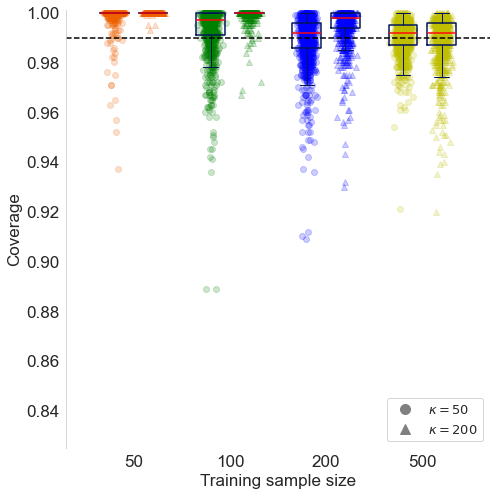

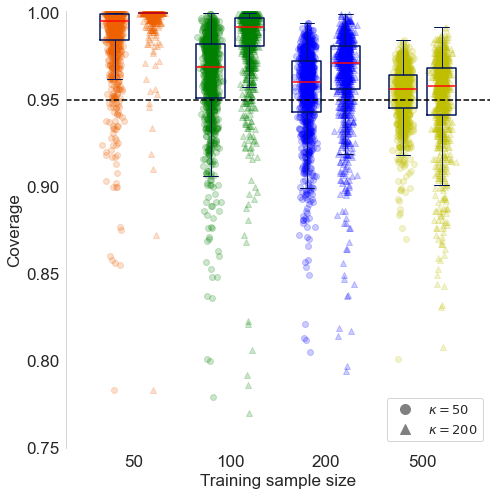

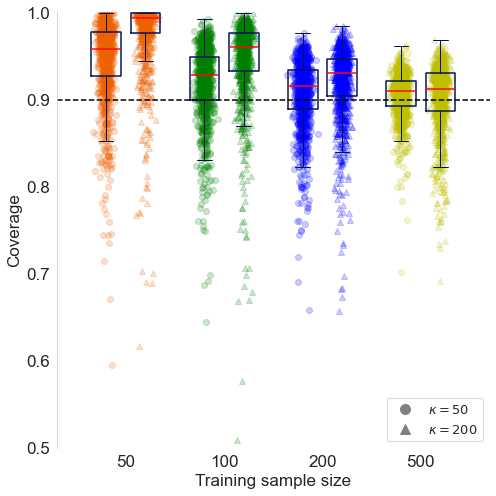

In [38]:
import matplotlib.patches as mpatches
import matplotlib.lines as mlines

##### Set style options here #####
boxprops = dict(linestyle='-', linewidth=1.5, color='#00145A')
flierprops = dict(marker='o', markersize=1, linestyle='none')
whiskerprops = dict(color='#00145A')
capprops = dict(color='#00145A')
medianprops = dict(linewidth=1.5, linestyle='-', color='#ff0808')

sns.set_style("whitegrid")
for kappa_50_data, kappa_200_data, alpha_level in zip(
    [iv_pb_coverage_df_kappa_50_alpha_01, iv_pb_coverage_df_kappa_50_alpha_05, iv_pb_coverage_df_kappa_50_alpha_1], 
    [iv_pb_coverage_df_kappa_200_alpha_01, iv_pb_coverage_df_kappa_200_alpha_05, iv_pb_coverage_df_kappa_200_alpha_1], 
    [0.01, 0.05, 0.1]
):
    fig = plt.figure(facecolor="white", figsize=(7, 7))
    ax = fig.add_subplot(111)

    # Extract data for each training size
    train_sizes = [50, 100, 200, 500]
    kappa_50_boxplot_data = [kappa_50_data[kappa_50_data['train_size'] == size]['iv_cov'].values for size in train_sizes]
    kappa_200_boxplot_data = [kappa_200_data[kappa_200_data['train_size'] == size]['iv_cov'].values for size in train_sizes]

    # Create boxplots with adjusted positions
    positions_kappa_50 = np.array(range(len(train_sizes))) - 0.2
    positions_kappa_200 = np.array(range(len(train_sizes))) + 0.2

    palette = ['#ee6100', 'g', 'b', 'y']  # Generate unique colors

    ax.boxplot(kappa_50_boxplot_data, positions=positions_kappa_50, widths=0.3, notch=False, 
               boxprops=dict(color='#00145A', linestyle='-', linewidth=1.5), 
               whiskerprops=dict(color='#00145A'), capprops=dict(color='#00145A'), 
               flierprops=dict(marker='o', markersize=1, linestyle='none'), 
               medianprops=dict(linewidth=1.5, linestyle='-', color='#ff0808'), showmeans=False, showfliers=False)
               
    ax.boxplot(kappa_200_boxplot_data, positions=positions_kappa_200, widths=0.3, notch=False, 
               boxprops=dict(color='#00145A', linestyle='-', linewidth=1.5), 
               whiskerprops=dict(color='#00145A'), capprops=dict(color='#00145A'), 
               flierprops=dict(marker='o', markersize=1, linestyle='none'), 
               medianprops=dict(linewidth=1.5, linestyle='-', color='#ff0808'), showmeans=False, showfliers=False)

    # Scatter plot
    palette_kappa_50 = ['#ee6100', 'g', 'b', 'y']
    palette_kappa_200 = ['#ee6100', 'g', 'b', 'y']

    for i, size in enumerate(train_sizes):
        xs_kappa_50 = np.random.normal(positions_kappa_50[i], 0.04, len(kappa_50_boxplot_data[i]))
        xs_kappa_200 = np.random.normal(positions_kappa_200[i], 0.04, len(kappa_200_boxplot_data[i]))

        ax.scatter(xs_kappa_50, kappa_50_boxplot_data[i], alpha=0.2, color=palette_kappa_50[i], label='Prediction balls')
        ax.scatter(xs_kappa_200, kappa_200_boxplot_data[i], alpha=0.2, color=palette_kappa_200[i], marker='^', label='Split-conformal')

    sns.despine(bottom=True)  # Remove right and top axis lines

    ax.set_xticks(range(len(train_sizes)))
    ax.set_xticklabels([str(size) for size in train_sizes], fontsize=17)

    if alpha_level == 0.01:
        ax.set_ylim(0.825, 1.001)
    elif alpha_level == 0.05:
        ax.set_ylim(0.75, 1.001)
    else:
        ax.set_ylim(0.5, 1.001)

    ax.set_xlabel('Training sample size', fontsize=17)
    ax.set_ylabel('Coverage', fontsize=17)
    ax.tick_params(labelsize=17)
    ax.axhline(y=1-alpha_level, color='black', linestyle='dashed')
    ax.grid(False)


    # Custom legend
    legend_handles = [
    ]
        
    legend_handles.append(mlines.Line2D([], [], color='gray', marker='o', linestyle='none', markersize=10, label=r'$\kappa = 50$'))
    legend_handles.append(mlines.Line2D([], [], color='gray', marker='^', linestyle='none', markersize=10, label=r'$\kappa = 200$'))
    ax.legend(handles=legend_handles, loc='lower right', fontsize=13)

    fig.tight_layout()
    filename = os.path.join(os.getcwd(),'pb_sphere_kappa_50_200_IV_coverage_' + str(alpha_level)[2:] + '.png')
    fig.savefig(filename, bbox_inches='tight', format='png', dpi = 75, transparent=True)
    plt.show()